# Assignment 8: LSTM for Google STock

In [80]:
!pip install matplotlib
!pip install numpy pandas torch

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


# Step 1 :Preprocess Data

In [114]:
data = pd.read_csv("Google_Stock_Price_Train.csv")

data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

data['Close'] = data['Close'].str.replace(',', '', regex=True).astype(float)

data = data[['Close']].values


In [115]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Create Dataset
def create_dataset(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback, 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

lookback = 60
X, y = create_dataset(data, lookback)

# Step 2: spliting dataset

In [116]:

# 80% train and 20% test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#  PyTorch into tensors
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, lookback, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, lookback, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# Step 3: Define LSTM Model

In [117]:


class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)  #  dropout layer as regularization
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  #  LSTM output
        x = self.fc(x)
        return x

model = StockPriceLSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Step 4: Train the Model

In [118]:

n_epochs = 30
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # Validation after each epoch
    model.eval()
    with torch.no_grad():
        train_rmse = torch.sqrt(loss_fn(model(X_train), y_train))
        test_rmse = torch.sqrt(loss_fn(model(X_test), y_test))
    print(f"Epoch {epoch + 1}/{n_epochs}, Train RMSE value: {train_rmse:.4f}, Test RMSE value: {test_rmse:.4f}")



Epoch 1/30, Train RMSE value: 0.1459, Test RMSE value: 0.0402
Epoch 2/30, Train RMSE value: 0.0711, Test RMSE value: 0.0302
Epoch 3/30, Train RMSE value: 0.0609, Test RMSE value: 0.0220
Epoch 4/30, Train RMSE value: 0.0538, Test RMSE value: 0.0245
Epoch 5/30, Train RMSE value: 0.0645, Test RMSE value: 0.0469
Epoch 6/30, Train RMSE value: 0.0529, Test RMSE value: 0.0313
Epoch 7/30, Train RMSE value: 0.0496, Test RMSE value: 0.0250
Epoch 8/30, Train RMSE value: 0.0537, Test RMSE value: 0.0333
Epoch 9/30, Train RMSE value: 0.0476, Test RMSE value: 0.0224
Epoch 10/30, Train RMSE value: 0.0540, Test RMSE value: 0.0346
Epoch 11/30, Train RMSE value: 0.0509, Test RMSE value: 0.0298
Epoch 12/30, Train RMSE value: 0.0441, Test RMSE value: 0.0229
Epoch 13/30, Train RMSE value: 0.0527, Test RMSE value: 0.0340
Epoch 14/30, Train RMSE value: 0.0454, Test RMSE value: 0.0256
Epoch 15/30, Train RMSE value: 0.0430, Test RMSE value: 0.0203
Epoch 16/30, Train RMSE value: 0.0418, Test RMSE value: 0.0207
E

# Step 5: Plot the Results

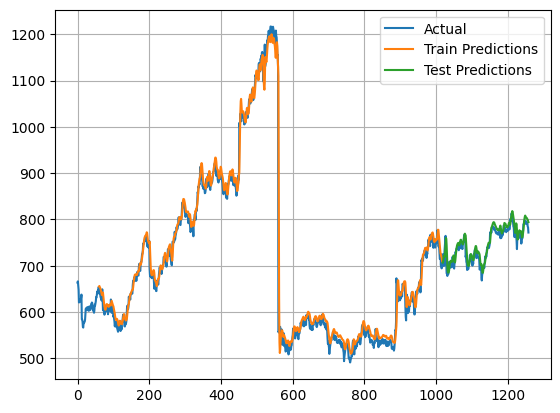

In [119]:

model.eval()
with torch.no_grad():
    train_pred = model(X_train).squeeze().cpu().numpy()
    test_pred = model(X_test).squeeze().cpu().numpy()

# Reversing scaling to original prices
train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.cpu().numpy())
y_test_inv = scaler.inverse_transform(y_test.cpu().numpy())

# Actual and predicted values
plt.plot(np.arange(len(data)), scaler.inverse_transform(data), label="Actual")
plt.plot(np.arange(lookback, train_size + lookback), train_pred, label="Train Predictions")
plt.plot(np.arange(train_size + lookback, len(data)), test_pred, label="Test Predictions")
plt.legend()
plt.grid()
plt.show()

# ------------------ Report -----------------

# Model Architecture & Training 
- The LSTM model implemented for this project will be used to predict stock prices with the PyTorch library. An architecture consisting of an LSTM model with two layers and a hidden size of 100 in each layer is necessary because this will enable the capturing of sequential dependencies associated with time series data. 
- Besides, a dropout layer has been added where the drop rate will be set to 0.2 with the purpose of overcoming overfitting by randomly setting neurons to zero during training. This is used for mapping the output of the LSTM onto one value representing the predicted stock price. 
- By default, the LSTM cells are using sigmoid and tanh as the activation functions. The output layer has a linear activation function, while Mean Squared Error has been used as the loss function. The optimization will be done by the Adam optimizer; the learning rate is set to 0.001, and this minimizes the error in the prediction.

# Results & Analysis
- This model has been trained for more than 30 epochs, and in each of them, the Root Mean Square Error values have been computed for the training and test sets. From the progress of the RMSEs, it can be seen that the values are continuously getting smaller, which is indicative of proper learning by the model. 
- Eventually, at the end of the training, the RMSEs for both the training and test datasets were low, indicating good performance with less overfitting. The last plot of actual versus predicted stock prices indicates that model predictions track the actual stock price trend with small deviations. 
- The extent to which this is matched-especially on the test set-indicates a pretty good generalization in the model, capturing the most important patterns in the stock price data.